In [1]:
from __future__ import print_function
# standard packages
import numpy as np
import mdtraj as md
import pandas as pd
import math
import random
import time

import matplotlib.pyplot as plt

# OpenMM
from simtk.openmm import app
import simtk.unit as unit

# OpenMMTools
import openmmtools as omt

# OpenPathSampling
import openpathsampling as paths
from openpathsampling.tools import refresh_output

# Visualization of PathTrees
import openpathsampling.visualize as ops_vis
#from openpathsampling.visualize import PathTree
from IPython.display import SVG

# the openpathsampling OpenMM engine
import openpathsampling.engines.openmm as eng

# always the most complicated bit
import openpathsampling.engines.toy as toys
%run toy_plot_helpers.py

from datetime import datetime

In [2]:
pes = (toys.OuterWalls([1.0,1.0], [0.0,0.0]) + 
       toys.Gaussian(-0.7, [7.5, 7.5], [-0.5, 0.0]) +
       toys.Gaussian(-0.7, [7.5, 7.5], [0.5, 0.0]))

plot = ToyPlot()
plot.contour_range = np.arange(-1.5, 1.0, 0.1)
plot.add_pes(pes)



In [3]:
topology = toys.Topology(n_spatial=2, masses=[1.0, 1.0], pes=pes)
toy_engine = toys.Engine({'integ': toys.LangevinBAOABIntegrator(dt=0.02, temperature=0.1, gamma=2.5),
                              'n_frames_max': 50000,
                              'n_steps_per_frame': 1}, topology)
template = toys.Snapshot(coordinates=np.array([[0.0, 0.0]]),
                         velocities=np.array([[0.0, 0.0]]),
                        engine=toy_engine)

In [4]:
toy_engine.current_snapshot = template
paths.PathMover.engine = toy_engine

In [5]:
def circle(snapshot, center):
    import math
    return math.sqrt((snapshot.xyz[0][0]-center[0])**2
                     + (snapshot.xyz[0][1]-center[1])**2)
# turns the circle function into a collective variable
# from collectivevariable.py
opA = paths.CoordinateFunctionCV(name="opA", f=circle, center=[-0.5, 0.0])
opB = paths.CoordinateFunctionCV(name="opB", f=circle, center=[0.5, 0.0])

In [6]:
# defines the volumes of state A and B as range of the circle functions
# with the respective center defined before
# from volume.py
stateA = paths.CVDefinedVolume(opA, 0.0, 0.2).named("A")
stateB = paths.CVDefinedVolume(opB, 0.0, 0.2).named("B")

In [7]:
FIXED_PATHLENGTH = 100

In [8]:
network = paths.FixedLengthTPSNetwork(stateA, stateB, length=FIXED_PATHLENGTH)
scheme = paths.OneWayShootingMoveScheme(network, engine=toy_engine)

In [9]:
# I'll fake an initial trajectory
delta = 1.0 / FIXED_PATHLENGTH
minimum = -0.5-delta
trajectory = paths.Trajectory([
    toys.Snapshot(coordinates=np.array([[minimum+k*delta, 0.0]]),
                  velocities=np.array([[0.1, 0.0]]),
                  engine=toy_engine)
    for k in range(FIXED_PATHLENGTH)
])

In [10]:
#print(trajectory[4999].xyz[0])
initial_conditions = paths.SampleSet.map_trajectory_to_ensembles(trajectory, network.sampling_ensembles)
#plot.plot([trajectory]);


In [11]:
#init_traj_ensemble = paths.LengthEnsemble(1) | paths.LengthEnsemble(2) | paths.LengthEnsemble(3)
init_traj_ensemble = paths.AllOutXEnsemble(stateA) | paths.AllOutXEnsemble(stateB)


In [30]:
# generate trajectory that includes frame in both states
trajectory = toy_engine.generate_n_frames(n_frames = 10000)

Trajectory[10000]


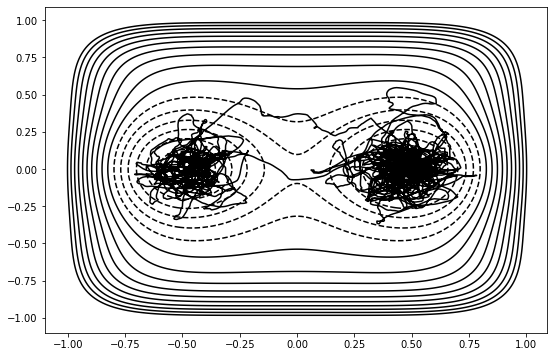

In [31]:
plot.plot([trajectory])
print(trajectory)

In [14]:
# produces a time stamp to use for file naming
TIME_STAMP = str(datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
storage = paths.Storage(str(TIME_STAMP) + "_simple_fixedlen.nc", "w", template=template)
simulation = paths.PathSampling(storage, scheme, initial_conditions)

In [15]:
simulation.run(10)


Working on Monte Carlo cycle number 10
Running for 2 seconds -  0.23 seconds per step
Estimated time remaining: 0 seconds
DONE! Completed 10 Monte Carlo cycles.


In [16]:
print(simulation.sample_set)
print(storage.list_stores())
print(storage.trajectories[2])


['stores', 'trajectories', 'topologies', 'snapshots', 'samples', 'samplesets', 'movechanges', 'steps', 'details', 'pathmovers', 'shootingpointselectors', 'engines', 'pathsimulators', 'transitions', 'networks', 'schemes', 'interfacesets', 'msouters', 'volumes', 'ensembles', 'tag', 'attributes', 'snapshot0']
Trajectory[100]


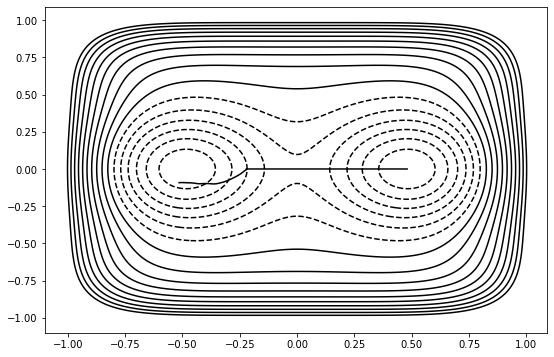

In [17]:
plot.plot([storage.trajectories[10]]);

In [18]:
"""# defines interfaces of A and B
# from high_level/interface_set.py
interfacesA = paths.VolumeInterfaceSet(opA, 0.0, [0.2, 0.3, 0.4])
interfacesB = paths.VolumeInterfaceSet(opB, 0.0, [0.2, 0.3, 0.4])"""

'# defines interfaces of A and B\n# from high_level/interface_set.py\ninterfacesA = paths.VolumeInterfaceSet(opA, 0.0, [0.2, 0.3, 0.4])\ninterfacesB = paths.VolumeInterfaceSet(opB, 0.0, [0.2, 0.3, 0.4])'

In [19]:
ms_outers = paths.MSOuterTISInterface.from_lambdas(
    {ifaces: 0.5
     for ifaces in [interfacesA, interfacesB]}
)
mstis = paths.MSTISNetwork(
    [(stateA, interfacesA),
     (stateB, interfacesB)],
    ms_outers=ms_outers
)

NameError: name 'interfacesA' is not defined

In [ ]:
initA = toys.Snapshot(
    coordinates=np.array([[-0.5, 0.0]]), 
    velocities=np.array([[1.0,0.0]]),
)
bootstrapA = paths.FullBootstrapping(
    transition=mstis.from_state[stateA],
    snapshot=initA,
    engine=toy_engine,
    forbidden_states=[stateB],
    extra_interfaces=[ms_outers.volume_for_interface_set(interfacesA)]
)
gsA = bootstrapA.run()

In [ ]:
initB = toys.Snapshot(
    coordinates=np.array([[0.5, 0.0]]), 
    velocities=np.array([[-1.0,0.0]]),
)

bootstrapB = paths.FullBootstrapping(
    transition=mstis.from_state[stateB], 
    snapshot=initB, 
    engine=toy_engine,
    forbidden_states=[stateA]
)
gsB = bootstrapB.run()

In [ ]:
plot.plot([s.trajectory for s in gsA]+[s.trajectory for s in gsB]);

In [ ]:
total_sample_set = paths.SampleSet.relabel_replicas_per_ensemble(
    [gsA, gsB])

In [ ]:
storage = paths.Storage("mstis_bootstrap.nc", "w")
storage.save(total_sample_set)
storage.save(toy_engine)
print("PathMovers:", len(storage.pathmovers))
print("Engines:", len(storage.engines))
print("Samples:", len(storage.samples))
print("SampleSets:", len(storage.samplesets))
print("Snapshots:", len(storage.snapshots))
print("Ensembles:", len(storage.ensembles))
print("CollectiveVariables:", len(storage.cvs))